In [6]:
#import all necessary liberty

%matplotlib inline
#import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np

import pandas as pd


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.optimizers import Adam
#from sklearn.utils import shuffle
import csv

#spliting dataset into traning set and test set
from sklearn.model_selection import train_test_split
#missing value handle
from sklearn.preprocessing import Imputer
#To shuffle the data set
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

import itertools

from scipy.stats import zscore

import os


Using TensorFlow backend.


In [147]:
class Neural_Network:
    data_frame = []
    df_after_shuffle = []
    data_set = []
    len_of_data_frame = []
    actual_x = []
    actual_y = []
    test_x = []
    test_y = []
    train_x = []
    train_y = []
    predicted_result = []
    rounded_predicted_result = []
    kfold_validation_score_store = []
    input_shape = 14
    learning_rate = .0001
    best_score = 0.0
    score = []
    cm = []
    
    def __init__(self,file_name):
        self.data_frame = pd.read_csv(file_name, sep='\t')
        self.len_of_data_frame = len(self.data_frame)
        
        self.shuffle_the_data()
        
        
    def shuffle_the_data(self):
        #shuffle the data set
        #np.random.seed(40)
        self.df_after_shuffle = self.data_frame.reindex(np.random.permutation(self.data_frame.index))
        self.df_after_shuffle.reset_index(inplace=True,drop=True)
        
        self.x_data_y_data_create()
    
    def x_data_y_data_create(self):
        self.data_set = self.df_after_shuffle.values
        self.actual_x = self.data_set[:,:14]
        self.actual_y = self.data_set[:,14:]
    
    def cross_validation_model_training(self,n_Of_fold=10):
        kf = KFold(n_Of_fold)
        fold = 0
        #self.best_score = self.score
        terget_names = ["NO","YES"]
        
        for train,test in kf.split(self.actual_x):
            fold += 1
            print("fold #{}".format(fold))
            self.train_x = self.actual_x[train]
            self.train_y = self.actual_y[train]
            self.test_x = self.actual_x[test]
            self.test_y = self.actual_y[test]
            
            model = Sequential([
            Dense(8,input_shape=(self.input_shape,),activation="relu"),
            Dense(7,activation="relu"),
            Dense(6,activation="relu"),
            Dense(2,activation="softmax")
            ])

            model.compile(
                Adam(lr=self.learning_rate),loss='sparse_categorical_crossentropy',metrics=['accuracy']
            )
            
            
            model.fit(self.train_x, self.train_y,
                      validation_data = (self.test_x,self.test_y),
                      batch_size=10,epochs=100,shuffle=True,verbose=0)
            
            #model.save("heart_attack_risk_prediction_fold_no_"+str(fold)+"_with_cross_validation.h5")
            
            rounded_predections = model.predict_classes(self.test_x,batch_size=10,verbose=0)
            self.rounded_predicted_result = rounded_predections
            #pred = model.predict(self.test_x)
            pred_class = model.predict_classes(self.test_x)
            self.score = model.evaluate(self.test_x, self.test_y)
            
            if(self.best_score<self.score[1]):
                self.best_score = self.score[1]
                self.model = model
            
            self.kfold_validation_score_store.append(self.score)
            
            print("\nFold {0} score : {1}\n Score: {2}".format(fold,self.score,self.best_score))
            
            #print("\n\n")
            
            self.confussion_matrix_generator()
            self.ROC_curve_generator()
            
            print(classification_report(pred_class,self.test_y,target_names=terget_names))
            
            self.performance()
            
            #print("\n\nnew\n\n")
            break
            
    def ROC_curve_generator(self):
        #ROC curve

        # calculate the fpr and tpr for all thresholds of the classification
        probs = self.model.predict_proba(self.test_x)
        preds = probs[:,1]
        fpr, tpr, threshold = metrics.roc_curve(self.test_y, preds)
        roc_auc = metrics.auc(fpr, tpr)

        # method I: plt
        import matplotlib.pyplot as plt
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
    def confussion_matrix_generator(self):
        #rounded_predections = self.model.predict_classes(self.test_x,batch_size=10,verbose=0)
        cm = confusion_matrix(self.test_y,self.rounded_predicted_result)
        self.cm = cm
        cm_plot_labels = ['no side effects', 'have side effects']
        self.plot_confusion_matrix(cm,cm_plot_labels,title='Confussion Matrix')

        
    def plot_confusion_matrix(self,cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        
    def performance(self):
        TN = self.cm[0][0]
        FP = self.cm[0][1]
        FN = self.cm[1][0]
        TP = self.cm[1][1]
        
        accuracy = (TP+TN)/83
        print("accuracy: ",accuracy)

        missclassafication_rate = 1-accuracy
        print("missclassafication_rate: ",missclassafication_rate)

        sensitivity = TP/(TP+FN)
        print("Sensitivity/Recall: ",sensitivity)

        spasificity = TN/(TN+FP)
        print("Spacificity: ",spasificity)

        precition = TP/(FP+TP)
        print("Precition: ",precition)

        prevalence = (FN+TP)/83
        print("prevalence: ",prevalence)

        PPV = TP/(TP+FP)
        print("Positive Predicted Value: ",PPV)

        NPV = TN/(TN+FN)
        print("Negative Predicted Value: ",NPV)

        beta = 0.5
        f_score = 1/(beta*(1/precition)+(1-beta)*(1/sensitivity))
        print("F Score: ",f_score)

In [148]:
nn = Neural_Network('data.tab')

In [149]:
nn.len_of_data_frame

834

In [150]:
nn.shuffle_the_data()

fold #1
84/84 [==============================] - 0s 149us/step

Fold 1 score : [0.48199106681914555, 0.8333333276567005]
 Score: 0.8333333276567005
Confusion matrix, without normalization
[[16 12]
 [ 2 54]]


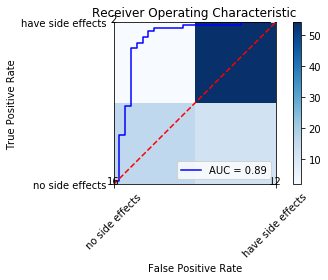

              precision    recall  f1-score   support

          NO       0.57      0.89      0.70        18
         YES       0.96      0.82      0.89        66

   micro avg       0.83      0.83      0.83        84
   macro avg       0.77      0.85      0.79        84
weighted avg       0.88      0.83      0.84        84

accuracy:  0.8433734939759037
missclassafication_rate:  0.15662650602409633
Sensitivity/Recall:  0.9642857142857143
Spacificity:  0.5714285714285714
Precition:  0.8181818181818182
prevalence:  0.6746987951807228
Positive Predicted Value:  0.8181818181818182
Negative Predicted Value:  0.8888888888888888
F Score:  0.8852459016393444


In [151]:
nn.cross_validation_model_training()

In [118]:
nn.best_score

0.8554216831563467

In [119]:
nn.kfold_validation_score_store

[[0.560037300700233, 0.7857142885526022],
 [0.5306575993696848, 0.7619047647430783],
 [0.5493174166906447, 0.726190481867109],
 [0.5666189364024571, 0.761904756228129],
 [0.45761259205370064, 0.8554216831563467],
 [0.5623444096151605, 0.7951807257640793],
 [0.49483235772833767, 0.8072289156626506],
 [0.49225867871778556, 0.8433735004390579],
 [0.43933174911751804, 0.8554216831563467],
 [0.567629389016025, 0.7469879460622029]]

In [120]:
#nn.model.get_weights()

In [121]:
nn.model.evaluate(nn.test_x,nn.test_y)

83/83 [==============================] - 0s 167us/step


[0.43886585838823433, 0.8433735004390579]

In [122]:
nn.model.evaluate(nn.actual_x,nn.actual_y)

834/834 [==============================] - 0s 153us/step


[0.4574988444360326, 0.8261390887290168]

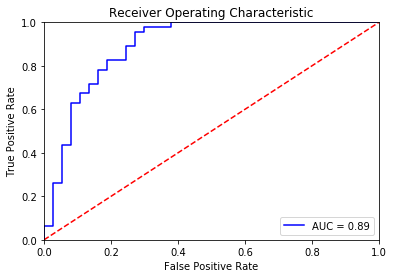

In [123]:
nn.ROC_curve_generetor()

Confusion matrix, without normalization
[[17 16]
 [ 0 51]]


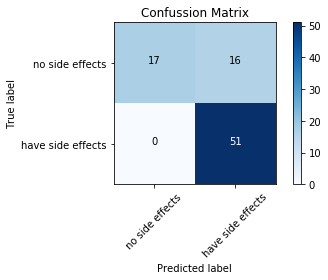

In [145]:
rounded_predections = nn.model.predict_classes(nn.test_x,batch_size=10,verbose=0)
cm = confusion_matrix(nn.test_y,rounded_predections)
cm_plot_labels = ['no side effects', 'have side effects']
nn.plot_confusion_matrix(cm,cm_plot_labels,title='Confussion Matrix')


Confusion matrix, without normalization
[[17 16]
 [ 0 51]]


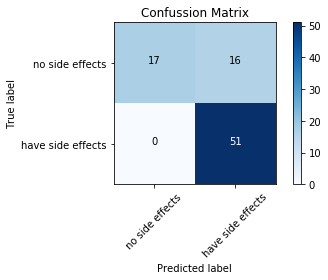

In [146]:
nn.confussion_matrix_generator(nn.rounded_predicted_result)